<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/notebooks/Analysis_of_adversarial_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/infomon/understanding_cnn
!pip install wget
!pip install innvestigate
  
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_imagenet.py"):
  shutil.move("/content/understanding_cnn/utils/utils_imagenet.py", "/content")
if not os.path.isdir("models"):
  shutil.move("/content/understanding_cnn/models", "/content")
if not os.path.isdir("images"):
  shutil.move("/content/understanding_cnn/data/images", "/content")
if not os.path.isfile("data_loader.py"):
  shutil.move("/content/understanding_cnn/data/data_loader.py", "/content")
  
!rm -r understanding_cnn

!pip install foolbox
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.criteria import TargetClassProbability
import numpy as np
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 317 (delta 43), reused 14 (delta 5), pack-reused 221
Receiving objects: 100% (317/317), 38.56 MiB | 31.36 MiB/s, done.
Resolving deltas: 100% (146/146), done.
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 245kB 3.4MB/s 
     |████████████████████████████████| 450kB 50.3MB/s 
     |████████████████████████████████| 71kB 32.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/d7/e7/c8/153284a6e5e5c3fd4da42a8453175b45e2e185e8b5a09ced06
Successfully built foolbox


Using TensorFlow backend.


In [0]:
import data_loader

data = data_loader.load_from_folder("images",(224,224))

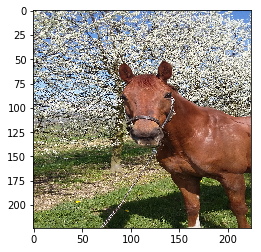

In [36]:
data[7][1]

In [37]:
keras.backend.set_learning_phase(0)
kmodel = VGG19(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

image, label = foolbox.utils.imagenet_example()
image = data[1][0].astype('float32')
label = 339

# run the attack
attack = LBFGSAttack(model=fmodel, criterion=TargetClassProbability(620, p=.8))
adversarial = attack(image[:, :, ::-1], label)

# show results
print(np.argmax(fmodel.predictions(adversarial)))
print(foolbox.utils.softmax(fmodel.predictions(adversarial))[620])
adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 5 predictions (adversarial: ", decode_predictions(preds, top=5))

620
0.8140559
Top 5 predictions (adversarial:  [[('n03642806', 'laptop', 0.80987006), ('n03832673', 'notebook', 0.03926562), ('n02123159', 'tiger_cat', 0.01576247), ('n02123045', 'tabby', 0.013446345), ('n03085013', 'computer_keyboard', 0.010453146)]]


W0503 17:50:43.962027 140513852741504 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


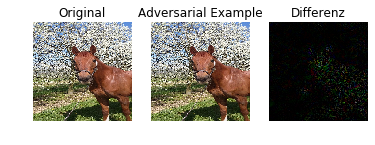

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure()

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial Example')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Differenz')
difference_img = adversarial[:, :, ::-1] - image

  
plt.imshow(difference_img / abs(difference_img).max())
plt.axis('off')

plt.show()

In [0]:
import innvestigate
import innvestigate.utils
import keras.applications.vgg19 as vgg19
import models.model_loader as model_loader


tmp = model_loader.VGG19(include_top=True, weights='imagenet')
patterns = tmp.get_patterns()

y_hat = label

# Get model
model, preprocess = vgg19.VGG19(), vgg19.preprocess_input
# Strip softmax layer
model_wo_softmax = innvestigate.utils.model_wo_softmax(model)
input_range = (-1,1)
# Create analyzer
analyzer = innvestigate.create_analyzer("pattern.attribution", 
                                        model_wo_softmax, 
                                        #neuron_selection_mode="index",
                                        patterns=patterns
                                        #reference_inputs=input_range[0],
                                        #steps=16
                                       )

# Add batch axis and preprocess
x = preprocess(image[None])
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)
# Add batch axis and preprocess
x = preprocess(adversarial_rgb)
# Apply analyzer w.r.t. maximum activated output-neuron
b = analyzer.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
b = b.sum(axis=np.argmax(np.asarray(b.shape) == 3))

max_value = max([np.max(np.abs(a)),np.max(np.abs(b))])

a /= max_value
b /= max_value

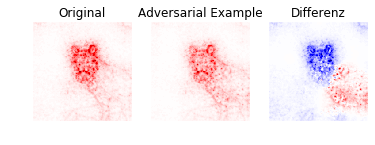

In [40]:
# Plot

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial Example')
plt.imshow(b[0], cmap="seismic", clim=(-1, 1))  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Differenz')
difference = b[0] - a[0]
im = plt.imshow(difference / abs(difference).max(),cmap="seismic", clim=(-1, 1))
#plt.colorbar(im, orientation='vertical')
plt.axis('off')

plt.show()